In [2]:
# @title Libraries and Packages

# Summarization
! pip install sumy
import sumy

from __future__ import absolute_import
from __future__ import division, print_function, unicode_literals

from sumy.parsers.html import HtmlParser
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer as SummarizerLsa
from sumy.summarizers.random import RandomSummarizer as SummarizerRandom
from sumy.summarizers.text_rank import TextRankSummarizer as SummarizerTextRank
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words

from string import punctuation
from string import punctuation
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')

LANGUAGE = "english"

# Summary evaluation
!pip install -q contractions rouge
import rouge

# Utils
import pandas as pd
import numpy as np
import scipy.stats
from random import sample
from random import seed
seed(42)

# Monitoring loops progress
from tqdm import tqdm
from functools import partial
tqdm_par = partial(tqdm, position=0, leave=True)
tqdm.pandas()

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Mute warnings
import warnings
warnings.filterwarnings('ignore')

# Directories and files
import os
from google.colab import drive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 809.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 22.5 MB/s eta 0:00:00
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21693 sha256=2062ff33def24ae9dbc46d252bcf52cb9f6a6adbc9beaf6379d4f1a34ed763af
  Stored in directory: /root/.cache/pip/wheels/64/22/90/b84fcc30e16598db20a0d41340616dbf9b1e82bbcc627b0b33
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=8696c2db1027d22eb7ce835e120962a76137d791f3af7a7275a3eb6115a8a86c
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built breadability docopt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 12.5 MB/s eta 0:00:00


In [3]:
# mount drive
drive.mount('/content/drive')

# set working directory
os.chdir('/content/drive/MyDrive/WIP/TM&S/progetto TM&S')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# load processed data
Data_clean = pd.read_csv(r'Preprocessing/wikisep_processed.csv', dtype="string")
Data_clean.drop(columns=Data_clean.columns[0], inplace=True)
Data_clean

,title,text,y,text_clean,y_clean
0,How to Sell Fine Art Online,"Before doing anything else, stop and sum up y...",Sell yourself first.,"Before doing anything else, stop and sum up yo...",Sell yourself first.
1,How to Be Well Read,Reading the classics is the very first thing ...,Read the classics before 1600.,Reading the classics is the very first thing y...,Read the classics before 1600.
2,How to Sell Fine Art Online,Depending on what scale you intend to sell yo...,Join online artist communities.,Depending on what scale you intend to sell you...,Join online artist communities.
3,How to Sell Fine Art Online,Get yourself out there as best as you can by ...,Make yourself public.,Get yourself out there as best as you can by a...,Make yourself public.
4,How to Sell Fine Art Online,"Given the hundreds of free blogging websites,...",Blog about your artwork.,"Given the hundreds of free blogging websites, ...",Blog about your artwork.
...,...,...,...,...,...
1387284,How to Identify Prints3,Unlike some of the other varieties of pre-pho...,Magnify the image.,Unlike some of the other varieties of pre-phot...,Magnify the image.
1387285,How to Identify Prints3,"If you find plate marks, you're always dealin...",Look for the absence of plate marks.,"If you find plate marks, you're always dealing...",Look for the absence of plate marks.
1387286,How to Identify Prints3,"Upon close examination, you should notice tha...",Look for the flatness of the ink.,"Upon close examination, you should notice that...",Look for the flatness of the ink.
1387287,How to Identify Prints3,Since the planographic surface holds and repe...,"Look for the illusion of shade, created by mu...",Since the planographic surface holds and repel...,"Look for the illusion of shade, created by mul..."


# Data exploration, outlier detection and vizualization

In [ ]:
## Helper functions

# compute number of words and sentences for text using sumy parse and converting text to DOM
def text_stats(text, suffix=''):
  tokenizer = Tokenizer(LANGUAGE)
  text = PlaintextParser.from_string(text,tokenizer).document
  n_word = len(text.words)
  n_sent = len(text.sentences)
  return {'n_word'+suffix:n_word, 'n_sent'+suffix:n_sent}

# apply text_stats to a df like Data
# outputs a df containing number of words and sentences for text for each text sample
def text_stats_df(df):
  print('processing text...')
  out_df = pd.DataFrame(list(df['text_clean'].progress_apply(lambda x: text_stats(x,'_text'))))
  print('processing y...')
  out_df = pd.concat([out_df,pd.DataFrame(list(df['y_clean'].progress_apply(lambda x: text_stats(x,'_y'))))], axis=1)
  out_df['title'] = list(df['title'])
  return out_df

# finds records that dont meet minimum number of words and sentences
def anomalous_search(stats_df, min_text_words=5, min_text_sent=1, cap_par_to_one=True, min_par=1):
  out_index_1 = np.where(stats_df.n_word_text < min_text_words)[0]
  out_index_3 = np.where(stats_df.n_sent_text < min_text_sent)[0]
  out_index_2 = np.where(stats_df.n_word_y == 0)[0]
  if cap_par_to_one:
    out_index_4 = np.where((stats_df.n_sent_y == 0) | (stats_df.n_sent_y > 1))[0]
  else:
    out_index_4 = np.where((stats_df.n_sent_y == 0) | (stats_df.n_sent_y < min_par))[0]
  out_index = list(out_index_1) + list(out_index_2) + list(out_index_3) + list(out_index_4)
  return list(np.unique(out_index))


# finds outlier based on mean and sd of text_stats_df cols
def outlier_search(stats_df, sd_factor=3):
  out_index_1 = np.where(stats_df.n_word_text > int(stats_df.n_word_text.mean()+sd_factor*stats_df.n_word_text.std()))[0]
  out_index_2 = np.where(stats_df.n_word_y > int(stats_df.n_word_y.mean()+sd_factor*stats_df.n_word_y.std()))[0]
  out_index_3 = np.where(stats_df.n_sent_text > int(stats_df.n_sent_text.mean()+sd_factor*stats_df.n_sent_text.std()))[0]
  out_index_4 = np.where(stats_df.n_sent_y > int(stats_df.n_sent_y.mean()+sd_factor*stats_df.n_sent_y.std()))[0]
  out_index = list(out_index_1) + list(out_index_2) + list(out_index_3) + list(out_index_4)
  return list(np.unique(out_index))


# vizualize distribution, code from TM&S lab4
def plot_distributions(dtf, x, bins=None, figsize=(10,5), title=None, bwm=None):
  title = x if(title == None) else title
  fig, ax = plt.subplots(figsize=figsize)
  fig.suptitle(title, fontsize=15)
  sns.distplot(dtf[x], hist=True, kde=True, kde_kws={"fill":True, 'bw_method':bwm}, ax=ax, bins=bins)
  ax.grid(True)
  ax.set(xlabel=None, yticklabels=[], yticks=[])

# given a list of titles outputs a reindexed slice of df based on title
def title_to_article(df, title_list):
  map = df.groupby('title').groups
  idx_list = [list(map[title]) for title in title_list]
  idx_list = [x for xs in idx_list for x in xs]
  return df.iloc[idx_list].reset_index(drop=True)

In [ ]:
# list of unique titles in the corpus
title_list = np.unique(Data_clean['title'])
print('numer of articles: '+str(len(title_list)))

numer of articles: 211825


In [ ]:
# compute stats
#Data_stats_by_par = text_stats_df(Data_clean)
#Data_stats_by_par.to_csv('wikisep_stats.csv')

In [ ]:
# load wikisep stats data
Data_stats_by_par_clean = pd.read_csv(r'Preprocessing/wikisep_stats.csv', dtype="string")
Data_stats_by_par_clean.drop(columns=Data_stats_by_par_clean.columns[0], inplace=True)
Data_stats_by_par_clean = Data_stats_by_par_clean.astype({'n_word_text': int, 'n_sent_text': int,
                                                          'n_word_y': int, 'n_sent_y': int})
Data_stats_by_par_clean

,n_word_text,n_sent_text,n_word_y,n_sent_y,title
0,114,6,3,1,How to Sell Fine Art Online
1,166,5,4,1,How to Be Well Read
2,255,8,4,1,How to Sell Fine Art Online
3,200,11,3,1,How to Sell Fine Art Online
4,170,8,4,1,How to Sell Fine Art Online
...,...,...,...,...,...
1387284,60,2,3,1,How to Identify Prints3
1387285,44,2,7,1,How to Identify Prints3
1387286,72,3,7,1,How to Identify Prints3
1387287,139,7,10,1,How to Identify Prints3


### by paragrph

In [ ]:
# create a copy of Data_clean and Data_stats_by_par_clean
Data = Data_clean.copy()
Data_stats_by_par = Data_stats_by_par_clean.copy()

In [ ]:
# find and remove anomalous records
og_len = len(Data_stats_by_par)
out_list = anomalous_search(Data_stats_by_par, min_text_words=5, min_text_sent=1)
Data_stats_by_par = Data_stats_by_par.drop(out_list).reset_index(drop=True)
print(str(np.round(len(out_list)*100/og_len,3)) + '% of records were droped being classified as anomalous')

# find and remove outliers
out_list = outlier_search(Data_stats_by_par)
Data_stats_by_par = Data_stats_by_par.drop(out_list).reset_index(drop=True)
print(str(np.round(len(out_list)*100/og_len,3)) + '% of records were droped being classified as outliers')

3.71% of records were droped being classified as anomalous
3.5% of records were droped being classified as outliers


In [ ]:
# summary statistics by paragraph
Data_stats_by_par.describe().drop(index='count')

,n_word_text,n_sent_text,n_word_y,n_sent_y
mean,65.628583,4.131920,6.585924,1.0
std,44.320720,2.699245,3.771652,0.0
min,5.000000,1.000000,1.000000,1.0
25%,31.000000,2.000000,4.000000,1.0
50%,57.000000,4.000000,6.000000,1.0
75%,92.000000,6.000000,8.000000,1.0
max,228.000000,14.000000,21.000000,1.0


In [ ]:
print('paragraph count: ' + str(len(Data_stats_by_par)))

paragraph count: 1287267


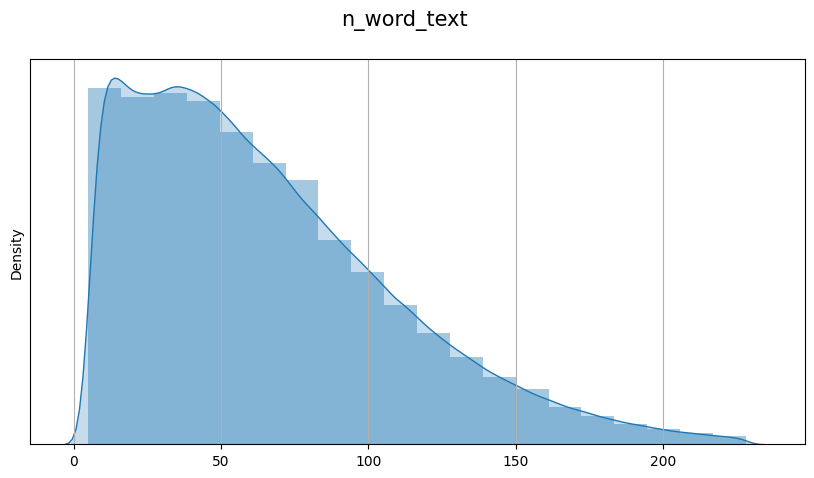

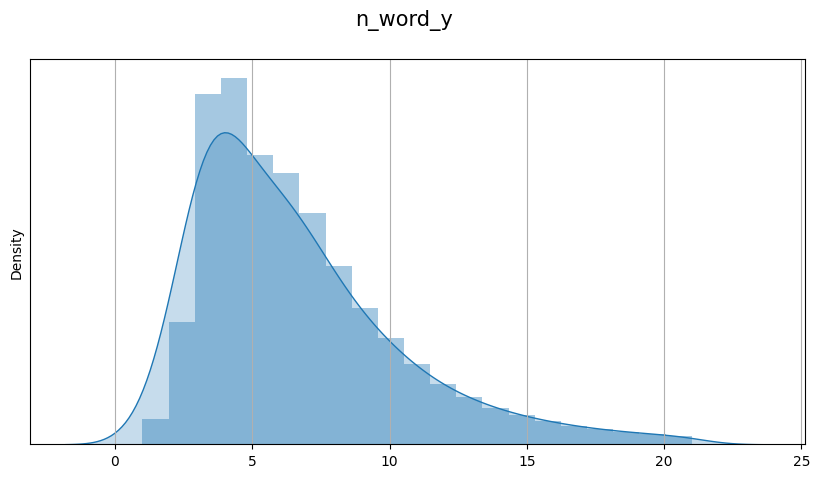

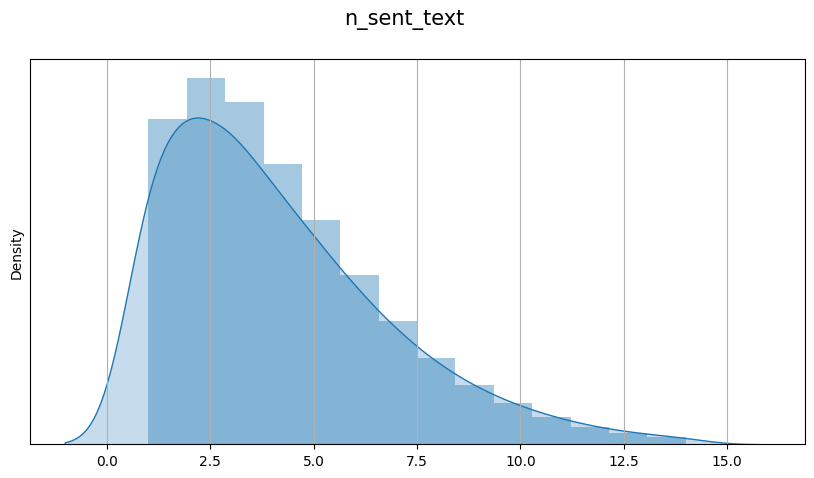

In [ ]:
# visualize distribution by paragraph
plot_distributions(Data_stats_by_par,'n_word_text',bins=20)
plot_distributions(Data_stats_by_par,'n_word_y',bins=Data_stats_by_par.n_word_y.max(), bwm=0.25)
plot_distributions(Data_stats_by_par,'n_sent_text',bins=Data_stats_by_par.n_sent_text.max(), bwm=0.25)

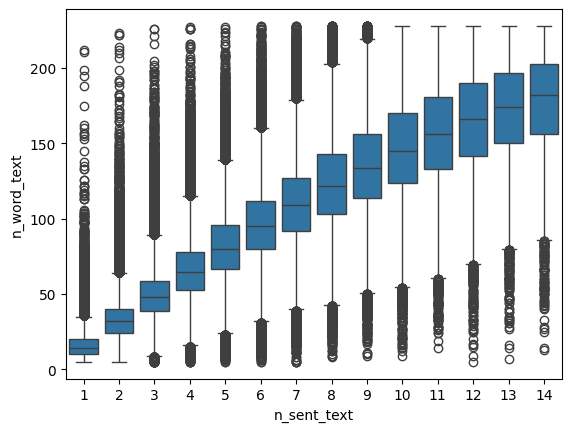

In [ ]:
sns.boxplot(x='n_sent_text', y='n_word_text', data=Data_stats_by_par)
plt.show()

### by article

In [ ]:
# compute statistics by article
Data_stats_by_article = Data_stats_by_par.groupby('title').sum()
Data_stats_by_article['n_par_text'] = Data_stats_by_par.groupby('title').count().iloc[:,0]
new_col_ord = ['n_word_text', 'n_sent_text', 'n_par_text', 'n_word_y', 'n_sent_y']
Data_stats_by_article = Data_stats_by_article.reindex(columns=new_col_ord)
Data_stats_by_article

,n_word_text,n_sent_text,n_par_text,n_word_y,n_sent_y
title,,,,,
"How to ""Bone"" a Holster to Fit Your Handgun",43,4,4,50,4
"How to ""Dust"" Hair",613,41,7,46,7
"How to ""Kick It"" in the End of a Race",265,19,7,66,7
"How to ""Ladder"" Jeans",561,38,8,82,8
"How to ""Ninja Loot"" in World of Warcraft",244,18,7,90,7
...,...,...,...,...,...
How to Zoom out on a Mac4,70,5,2,20,2
How to Zoom with the Camera on Android1,108,8,3,14,3
How to Zoom with the Camera on Android2,86,8,3,14,3


In [ ]:
# find and remove anomalous records
og_len = len(Data_stats_by_article)
out_list = anomalous_search(Data_stats_by_article, cap_par_to_one=False, min_par=1)
out_list = Data_stats_by_article.index[out_list]
map = Data.groupby('title').groups
index_drop_list = []
for title in out_list:
  index_drop_list = index_drop_list + list(map[title])
index_drop_list = list(set(index_drop_list))
Data_stats_by_article = Data_stats_by_article.drop(out_list)
print(str(np.round(len(out_list)*100/og_len,3)) + '% of records were droped being classified as anomalous')

# find and remove outliers
out_list = outlier_search(Data_stats_by_article)
out_list = Data_stats_by_article.index[out_list]
map = Data.groupby('title').groups
index_drop_list = []
for title in out_list:
  index_drop_list = index_drop_list + list(map[title])
index_drop_list = list(set(index_drop_list))
Data_stats_by_article = Data_stats_by_article.drop(out_list).reset_index().set_index('title')
print(str(np.round(len(out_list)*100/og_len,3)) + '% of records were droped being classified as outliers')

0.0% of records were droped being classified as anomalous
4.401% of records were droped being classified as outliers


In [ ]:
# summary statistics
Data_stats_by_article.describe()

,n_word_text,n_sent_text,n_par_text,n_word_y,n_sent_y
count,197675.000000,197675.000000,197675.000000,197675.00000,197675.000000
mean,353.020589,22.384687,5.614923,37.15744,5.614923
std,311.851466,18.637930,3.453735,24.95912,3.453735
min,5.000000,1.000000,1.000000,1.00000,1.000000
25%,131.000000,9.000000,3.000000,19.00000,3.000000
50%,274.000000,18.000000,5.000000,30.00000,5.000000
75%,464.000000,29.000000,7.000000,49.00000,7.000000
max,1674.000000,101.000000,19.000000,138.00000,19.000000


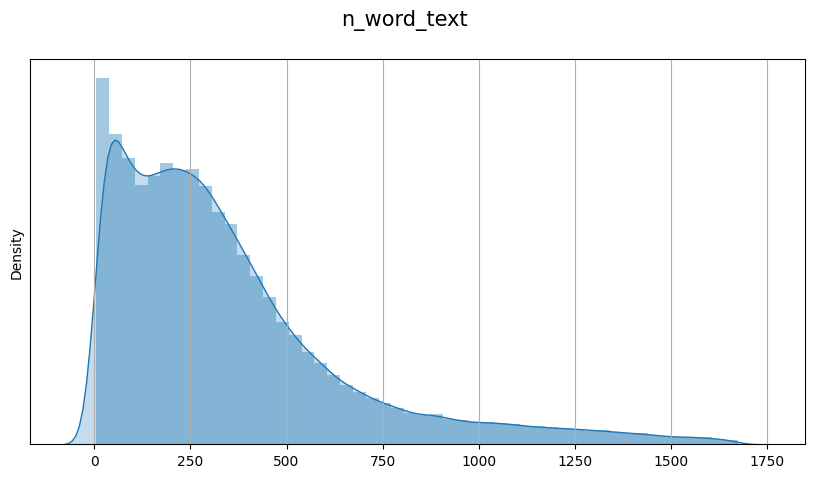

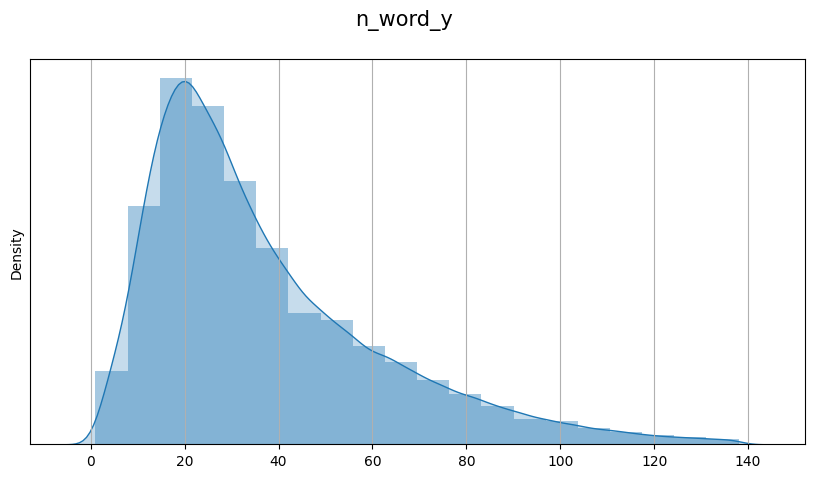

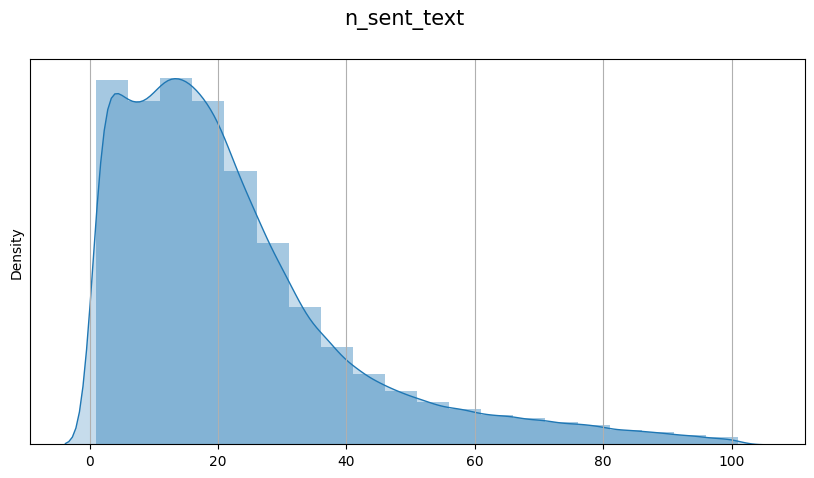

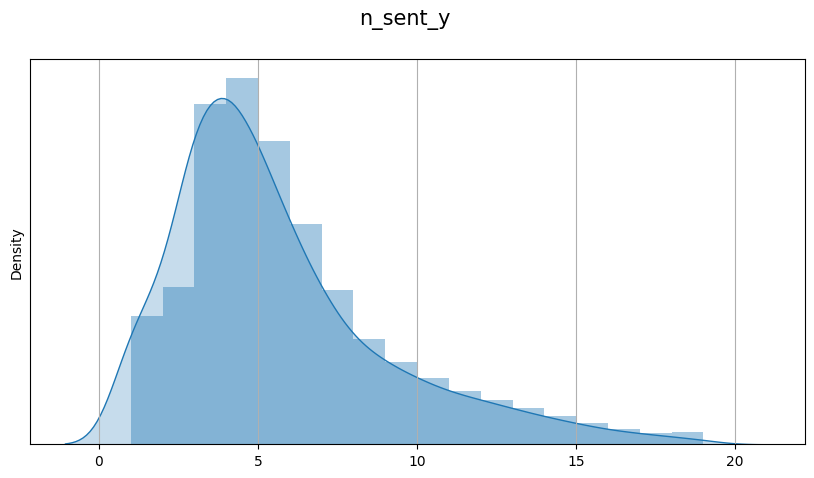

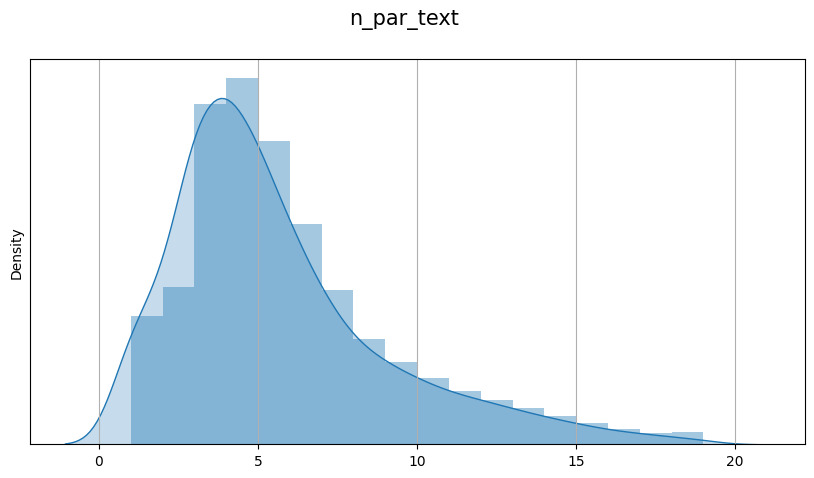

In [ ]:
# visualize distribution by article
plot_distributions(Data_stats_by_article, 'n_word_text', bins=50)
plot_distributions(Data_stats_by_article, 'n_word_y', bins=20)
plot_distributions(Data_stats_by_article, 'n_sent_text', bins=20)
plot_distributions(Data_stats_by_article, 'n_sent_y', bins=Data_stats_by_article.n_sent_y.max()-1, bwm=0.2)
plot_distributions(Data_stats_by_article, 'n_par_text', bins=Data_stats_by_article.n_par_text.max()-1, bwm=0.2)

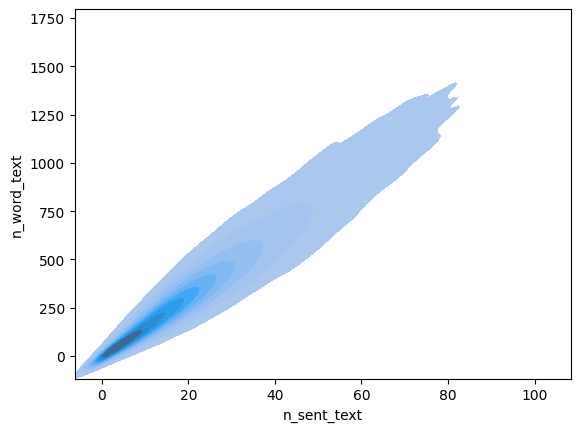

In [ ]:
sns.kdeplot(x='n_sent_text', y='n_word_text', data=Data_stats_by_article, fill=True)
plt.show()

<Axes: xlabel='n_sent_y', ylabel='n_sent_text'>

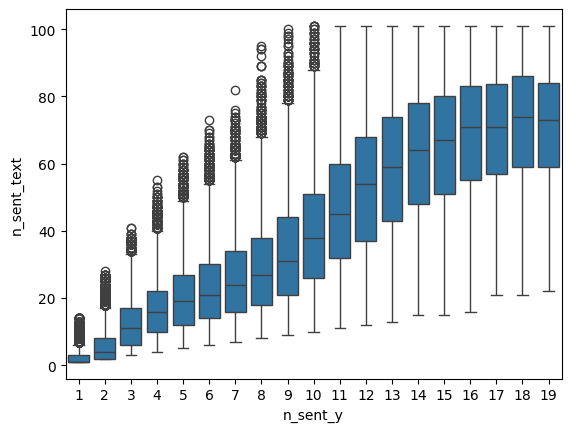

In [ ]:
sns.boxplot(x='n_sent_y', y='n_sent_text', data=Data_stats_by_article)

# Summarization

In [ ]:
## Helper functions

def summarize(text, tokenizer, stemmer, summarizer, red_factor=1):
    if type(text) == str:
      parser = PlaintextParser.from_string(text, tokenizer)
      doc = parser.document
      par_count = len(parser.document.paragraphs)
    else:
      doc = text
      par_count = 1
    sum_length = par_count//red_factor
    if sum_length>0:
      summary = summarizer(doc, sum_length)
    else:
      summary = summarizer(doc, 1)
    return ' '.join([str(sentence) for sentence in summary])

def summarize_bypar(text, tokenizer, stemmer, summarizer, red_factor=1):
    parser = PlaintextParser.from_string(text, tokenizer)
    par = parser.document.paragraphs
    summary = [summarize(p, tokenizer, stemmer, summarizer) for p in par]
    if red_factor==1:
      summary = ' '.join([str(sentence) for sentence in summary])
    else:
      summary = '\n\n'.join([str(sentence) for sentence in summary])
      summary = summarize(str(summary), tokenizer, stemmer, summarizer, red_factor)
    return summary

def evaluate_summary(y, predicted):
  if y.strip(punctuation).strip() == '' or predicted.strip(punctuation).strip()=='':
    return {"rouge-1":np.nan, "rouge-2": np.nan, "rouge-L": np.nan,
          "avg rouge":np.nan}
  else:
    rouge_score = rouge.Rouge()
    scores = rouge_score.get_scores(predicted, y, avg=True, ignore_empty=True)
    score_1 = round(scores['rouge-1']['f'], 2)
    score_2 = round(scores['rouge-2']['f'], 2)
    score_L = round(scores['rouge-l']['f'], 2)
    return {"rouge-1":score_1, "rouge-2": score_2, "rouge-L": score_L,
            "avg rouge":round(np.mean([score_1,score_2,score_L]), 2)}

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h


def compute_sum_stats(summary_df, stat = 'avg rouge'):
  df1 = pd.DataFrame(list(summary_df['rouge_lsa']))
  df2 = pd.DataFrame(list(summary_df['rouge_lsa_bypar']))
  df3 = pd.DataFrame(list(summary_df['rouge_textrank']))
  df4 = pd.DataFrame(list(summary_df['rouge_textrank_bypar']))
  df5 = pd.DataFrame(list(summary_df['rouge_random']))
  df6 = pd.DataFrame(list(summary_df['rouge_random_bypar']))

  rouge_lsa_stats = df1.describe()
  rouge_lsa_bypar_stats = df2.describe()
  rouge_textrank_stats = df3.describe()
  rouge_textrank_bypar_stats = df4.describe()
  rouge_random_stats = df5.describe()
  rouge_random_bypar_stats = df6.describe()

  temp1 = rouge_lsa_stats.loc[['mean','std'], stat]
  temp2 = rouge_lsa_bypar_stats.loc[['mean','std'], stat]
  temp3 = rouge_textrank_stats.loc[['mean','std'], stat]
  temp4 = rouge_textrank_bypar_stats.loc[['mean','std'], stat]
  temp5 = rouge_random_stats.loc[['mean','std'], stat]
  temp6 = rouge_random_bypar_stats.loc[['mean','std'], stat]

  temp1 = pd.DataFrame(temp1.rename('LSA'))
  temp2 = pd.DataFrame(temp2.rename('LSAp'))
  temp3 = pd.DataFrame(temp3.rename('TR'))
  temp4 = pd.DataFrame(temp4.rename('TRp'))
  temp5 = pd.DataFrame(temp5.rename('RND'))
  temp6 = pd.DataFrame(temp6.rename('RNDp'))

  h1 = mean_confidence_interval(df1[stat], confidence=0.95)
  h2 = mean_confidence_interval(df2[stat], confidence=0.95)
  h3 = mean_confidence_interval(df3[stat], confidence=0.95)
  h4 = mean_confidence_interval(df4[stat], confidence=0.95)
  h5 = mean_confidence_interval(df5[stat], confidence=0.95)
  h6 = mean_confidence_interval(df6[stat], confidence=0.95)

  h_dict = {'LSA':[h1],'LSAp':[h2],'TR':[h3],'TRp':[h4],'RND':[h5],'RNDp':[h6]}
  res_df_1 = pd.concat((temp1, temp2, temp3, temp4, temp5, temp6),axis=1)
  res_df_2 = pd.DataFrame(h_dict, index=['CI95±'])

  return pd.concat((res_df_1,res_df_2),axis=0)

In [ ]:
name_conv = {'LSA':'rouge_lsa','LSAp':'rouge_lsa_bypar','TR':'rouge_textrank','TRp':'rouge_textrank_bypar',
             'RND':'rouge_random','RNDp':'rouge_random_bypar'}

### Data selection

In [ ]:
# selection parameters
min_par_words = 10
min_par_sent = 3
min_text_words = 100
min_text_sent = 2
min_text_par = 6
sd_factor = 3

In [ ]:
# create a copy of Data_clean and Data_stats_by_par_clean
Data = Data_clean.copy()
Data_stats_by_par = Data_stats_by_par_clean.copy()

## by paragraph
print('by paragraph')
# find and remove anomalous records
og_len = len(Data_stats_by_par)
out_list = anomalous_search(Data_stats_by_par, min_text_words=min_par_words, min_text_sent=min_par_sent)
Data = Data.drop(out_list).reset_index(drop=True)
Data_stats_by_par = Data_stats_by_par.drop(out_list).reset_index(drop=True)
print(str(np.round(len(out_list)*100/og_len,3)) + '% of records did not meet the requirements and were droped')

# find and remove outliers
out_list = outlier_search(Data_stats_by_par, sd_factor=sd_factor)
Data = Data.drop(out_list).reset_index(drop=True)
Data_stats_by_par = Data_stats_by_par.drop(out_list).reset_index(drop=True)
print(str(np.round(len(out_list)*100/og_len,3)) + '% of records were droped being classified as outliers')


## by article
print('by aricle')
# compute statistics by article
Data_stats_by_article = Data_stats_by_par.groupby('title').sum()
Data_stats_by_article['n_par_text'] = Data_stats_by_par.groupby('title').count().iloc[:,0]

# find and remove anomalous records
og_len = len(Data_stats_by_article)
out_list = anomalous_search(Data_stats_by_article, cap_par_to_one=False, min_par=min_text_par,
                            min_text_sent=min_text_sent, min_text_words=min_text_words )
out_list = Data_stats_by_article.index[out_list]
map = Data.groupby('title').groups
index_drop_list = []
for title in out_list:
  index_drop_list = index_drop_list + list(map[title])
index_drop_list = list(set(index_drop_list))
Data = Data.drop(index_drop_list).reset_index(drop=True)
Data_stats_by_article = Data_stats_by_article.drop(out_list)
print(str(np.round(len(out_list)*100/og_len,3)) + '% of records did not meet the requirements and were droped')

# find and remove outliers
out_list = outlier_search(Data_stats_by_article, sd_factor=sd_factor)
out_list = Data_stats_by_article.index[out_list]
map = Data.groupby('title').groups
index_drop_list = []
for title in out_list:
  index_drop_list = index_drop_list + list(map[title])
index_drop_list = list(set(index_drop_list))
Data = Data.drop(index_drop_list).reset_index(drop=True)
Data_stats_by_article = Data_stats_by_article.drop(out_list).reset_index().set_index('title')
print(str(np.round(len(out_list)*100/og_len,3)) + '% of records were droped being classified as outliers')

# list of unique titles in the cleaned corpus
title_list = np.unique(Data['title'])
print('numer of articles: '+str(len(title_list)))

by paragraph
35.75% of records did not meet the requirements and were droped
2.279% of records were droped being classified as outliers
by aricle
71.914% of records did not meet the requirements and were droped
0.88% of records were droped being classified as outliers
numer of articles: 47225


In [ ]:
Data_stats_by_article.describe()

,n_word_text,n_sent_text,n_word_y,n_sent_y,n_par_text
count,47225.000000,47225.000000,47225.000000,47225.000000,47225.000000
mean,885.192419,55.074452,55.728216,9.720106,9.720106
std,455.719001,26.358124,24.200335,3.703615,3.703615
min,109.000000,18.000000,6.000000,6.000000,6.000000
25%,534.000000,35.000000,37.000000,7.000000,7.000000
50%,765.000000,48.000000,52.000000,9.000000,9.000000
75%,1150.000000,70.000000,70.000000,12.000000,12.000000
max,2506.000000,149.000000,143.000000,23.000000,23.000000


In [ ]:
# select a subset of the corpus based on title
n_sample = 1000
title_list_slice = sample(list(title_list), n_sample)
Data_slice = title_to_article(Data,title_list_slice)

# title to index map for document retrival
map = Data_slice.groupby('title').groups

### reduction = 1

In [ ]:
# create a dataframe containing title, text, and target summary
ref_text = []
ref_sum = []

for title in tqdm(title_list_slice):
  cur_df = Data_slice.iloc[map[title]]
  text = '\n\n'.join(cur_df['text_clean'])
  ref_text.append(text)
  sum = ' '.join(cur_df['y_clean'])
  ref_sum.append(sum)

summary_df_1 = pd.DataFrame({'title':title_list_slice, 'ref_text':ref_text, 'ref_sum':ref_sum})
summary_df_1

100%|██████████| 1000/1000 [00:00<00:00, 1117.79it/s]


,title,ref_text,ref_sum
0,How to Survive Your Freshman Year in High School2,Though freshmen in high school aren't quite as...,Be especially outgoing at first. Try out diffe...
1,How to Deal With Emotional Abuse from Your Par...,If you feel threatened or upset with your pare...,Find safe places in your home. Go to a safe pl...
2,How to Pass the Bar Exam,There are three ways to study for the Bar exam...,Assess your options in light of your particula...
3,How to Clean Gravel2,Use tin snips or heavy shears to cut a 2x2 foo...,Cut a section of metal hardware cloth. Shape t...
4,How to Get a Self Published Book into Libraries,Many people are wary of self-published books b...,Ensure that your book is high quality. Be prof...
...,...,...,...
995,How to Do Dance Aerobics1,It is important to warm up at the beginning of...,March in place. Do a hip roll. Squat and pump ...
996,How to Put on a Captive Ring1,"Depending on the location of your piercing, yo...",Wait three months after the initial piercing. ...
997,How to Bake Fluffy Pound Cake with a Variety o...,"Once that is set up, whip the butter with a ha...",Put the butter in a metal or a deep glass bowl...
998,How to Attend Crisis Intervention Counseling,"A crisis can be many things, and may vary from...",Identify a crisis situation. Find a clinic ser...


In [ ]:
# initialize tokenizer and stemmer
tokenizer = Tokenizer(LANGUAGE)
stemmer = Stemmer(LANGUAGE)
red_factor = 1

# summarize lsa
print('summarize lsa...')
summarizer = SummarizerLsa(stemmer)
summarizer.stop_words = get_stop_words(LANGUAGE)
summary_df_1['sum_lsa'] = summary_df_1['ref_text'].progress_apply(lambda x: summarize(x, tokenizer, stemmer, summarizer, red_factor))
summary_df_1['sum_lsa_bypar'] = summary_df_1['ref_text'].progress_apply(lambda x: summarize_bypar(x, tokenizer, stemmer, summarizer, red_factor))

# summarize TextRank
print('summarize TextRank...')
summarizer = SummarizerTextRank(stemmer)
summarizer.stop_words = get_stop_words(LANGUAGE)
summary_df_1['sum_textrank'] = summary_df_1['ref_text'].progress_apply(lambda x: summarize(x, tokenizer, stemmer, summarizer, red_factor))
summary_df_1['sum_textrank_bypar'] = summary_df_1['ref_text'].progress_apply(lambda x: summarize_bypar(x, tokenizer, stemmer, summarizer, red_factor))

# summarize Random
print('summarize random...')
summarizer = SummarizerRandom(stemmer)
summarizer.stop_words = get_stop_words(LANGUAGE)
summary_df_1['sum_random'] = summary_df_1['ref_text'].progress_apply(lambda x: summarize(x, tokenizer, stemmer, summarizer, red_factor))
summary_df_1['sum_random_bypar'] = summary_df_1['ref_text'].progress_apply(lambda x: summarize_bypar(x, tokenizer, stemmer, summarizer, red_factor))

# evaluete summary
print('evaluation...')
summary_df_1['rouge_lsa'] = summary_df_1.progress_apply(lambda x: evaluate_summary(x.ref_sum, x.sum_lsa),axis=1)
summary_df_1['rouge_lsa_bypar'] = summary_df_1.progress_apply(lambda x: evaluate_summary(x.ref_sum, x.sum_lsa_bypar),axis=1)
summary_df_1['rouge_textrank'] = summary_df_1.progress_apply(lambda x: evaluate_summary(x.ref_sum, x.sum_textrank),axis=1)
summary_df_1['rouge_textrank_bypar'] = summary_df_1.progress_apply(lambda x: evaluate_summary(x.ref_sum, x.sum_textrank_bypar),axis=1)
summary_df_1['rouge_random'] = summary_df_1.progress_apply(lambda x: evaluate_summary(x.ref_sum, x.sum_random),axis=1)
summary_df_1['rouge_random_bypar'] = summary_df_1.progress_apply(lambda x: evaluate_summary(x.ref_sum, x.sum_random_bypar),axis=1)

summarize lsa...


100%|██████████| 1000/1000 [00:35<00:00, 27.86it/s]


summarize TextRank...


100%|██████████| 1000/1000 [00:30<00:00, 32.99it/s]


summarize random...


100%|██████████| 1000/1000 [00:01<00:00, 575.02it/s]


evaluation...


100%|██████████| 1000/1000 [00:13<00:00, 72.56it/s]


In [ ]:
summary_df_1.head()

,title,ref_text,ref_sum,sum_lsa,sum_lsa_bypar,sum_textrank,sum_textrank_bypar,sum_random,sum_random_bypar,rouge_lsa,rouge_lsa_bypar,rouge_textrank,rouge_textrank_bypar,rouge_random,rouge_random_bypar
0,How to Survive Your Freshman Year in High School2,Though freshmen in high school aren't quite as...,Be especially outgoing at first. Try out diffe...,"So, say hi to the girl in your French class, b...","So, say hi to the girl in your French class, b...",Though freshmen in high school aren't quite as...,Though freshmen in high school aren't quite as...,Get to know the people in your gym class. You ...,You may not run in to some of them academicall...,"{'rouge-1': 0.1, 'rouge-2': 0.01, 'rouge-L': 0...","{'rouge-1': 0.12, 'rouge-2': 0.02, 'rouge-L': ...","{'rouge-1': 0.17, 'rouge-2': 0.02, 'rouge-L': ...","{'rouge-1': 0.13, 'rouge-2': 0.01, 'rouge-L': ...","{'rouge-1': 0.18, 'rouge-2': 0.01, 'rouge-L': ...","{'rouge-1': 0.09, 'rouge-2': 0.01, 'rouge-L': ..."
1,How to Deal With Emotional Abuse from Your Par...,If you feel threatened or upset with your pare...,Find safe places in your home. Go to a safe pl...,You may want to go to the bathroom if you shar...,You may want to go to the bathroom if you shar...,If you feel threatened or upset with your pare...,If you feel threatened or upset with your pare...,Lock the door if necessary. If you feel uncomf...,Look around for safe spaces within your own ho...,"{'rouge-1': 0.18, 'rouge-2': 0.03, 'rouge-L': ...","{'rouge-1': 0.17, 'rouge-2': 0.02, 'rouge-L': ...","{'rouge-1': 0.29, 'rouge-2': 0.09, 'rouge-L': ...","{'rouge-1': 0.22, 'rouge-2': 0.04, 'rouge-L': ...","{'rouge-1': 0.23, 'rouge-2': 0.06, 'rouge-L': ...","{'rouge-1': 0.23, 'rouge-2': 0.04, 'rouge-L': ..."
2,How to Pass the Bar Exam,There are three ways to study for the Bar exam...,Assess your options in light of your particula...,Repeat-takers (especially those who received l...,Repeat-takers (especially those who received l...,There are three ways to study for the Bar exam...,Students who performed well in law school and ...,The method that is right for you will depend o...,A traditional Bar preparation course may not b...,"{'rouge-1': 0.19, 'rouge-2': 0.04, 'rouge-L': ...","{'rouge-1': 0.18, 'rouge-2': 0.05, 'rouge-L': ...","{'rouge-1': 0.2, 'rouge-2': 0.06, 'rouge-L': 0...","{'rouge-1': 0.21, 'rouge-2': 0.07, 'rouge-L': ...","{'rouge-1': 0.24, 'rouge-2': 0.06, 'rouge-L': ...","{'rouge-1': 0.24, 'rouge-2': 0.03, 'rouge-L': ..."
3,How to Clean Gravel2,Use tin snips or heavy shears to cut a 2x2 foo...,Cut a section of metal hardware cloth. Shape t...,Use tin snips or heavy shears to cut a 2x2 foo...,Use tin snips or heavy shears to cut a 2x2 foo...,The section of hardware cloth will act as a si...,Hardware cloth is metal or plastic wire mesh t...,"Once it is cut, roll or fold two edges of the ...",Hardware cloth is metal or plastic wire mesh t...,"{'rouge-1': 0.21, 'rouge-2': 0.03, 'rouge-L': ...","{'rouge-1': 0.28, 'rouge-2': 0.13, 'rouge-L': ...","{'rouge-1': 0.36, 'rouge-2': 0.15, 'rouge-L': ...","{'rouge-1': 0.3, 'rouge-2': 0.11, 'rouge-L': 0...","{'rouge-1': 0.17, 'rouge-2': 0.02, 'rouge-L': ...","{'rouge-1': 0.24, 'rouge-2': 0.02, 'rouge-L': ..."
4,How to Get a Self Published Book into Libraries,Many people are wary of self-published books b...,Ensure that your book is high quality. Be prof...,Many people are wary of self-published books b...,"Also, choose your bindings carefully, as libra...",Ensure that the cover makes the book look prof...,Ensure that the cover makes the book look prof...,Many people are wary of self-published books b...,Many people are wary of self-published books b...,"{'rouge-1': 0.14, 'rouge-2': 0.01, 'rouge-L': ...","{'rouge-1': 0.13, 'rouge-2': 0.02, 'rouge-L': ...","{'rouge-1': 0.16, 'rouge-2': 0.03, 'rouge-L': ...","{'rouge-1': 0.18, 'rouge-2': 0.03, 'rouge-L': ...","{'rouge-1': 0.18, 'rouge-2': 0.04, 'rouge-L': ...","{'rouge-1': 0.17, 'rouge-2': 0.04, 'rouge-L': ..."


In [ ]:
sum_stats_1 = compute_sum_stats(summary_df_1, stat = 'avg rouge')
sum_stats_1

,LSA,LSAp,TR,TRp,RND,RNDp
mean,0.135610,0.141500,0.151180,0.147750,0.145120,0.148950
std,0.047230,0.049016,0.052524,0.051140,0.048427,0.050610
CI95±,0.002931,0.003042,0.003259,0.003173,0.003005,0.003141


,rouge-1,rouge-2,rouge-L,avg rouge
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.205320,0.052410,0.195960,0.151180
std,0.065301,0.037828,0.061911,0.052524
min,0.000000,0.000000,0.000000,0.000000
25%,0.160000,0.030000,0.150000,0.110000
50%,0.200000,0.050000,0.190000,0.150000
75%,0.250000,0.070000,0.230000,0.180000
max,0.440000,0.230000,0.430000,0.360000


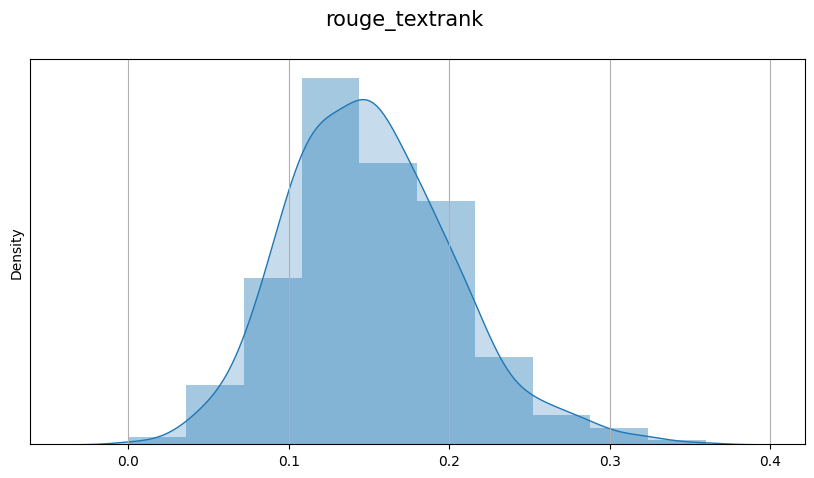

In [ ]:
best_name = name_conv[sum_stats_1.loc['mean',:].idxmax()]
best = pd.DataFrame(list(summary_df_1[best_name]))
plot_distributions(best,'avg rouge', bins=10, title=best_name)
best.describe()

In [ ]:
summary_df_1.to_csv('Summary/summary_1k_red1.csv')

### reduction = 2

In [ ]:
# create a dataframe containing title, text, and target summary
ref_text = []
ref_sum = []

for title in tqdm(title_list_slice):
  cur_df = Data_slice.iloc[map[title]]
  text = '\n\n'.join(cur_df['text_clean'])
  ref_text.append(text)
  sum = ' '.join(cur_df['y_clean'])
  ref_sum.append(sum)

summary_df_2 = pd.DataFrame({'title':title_list_slice, 'ref_text':ref_text, 'ref_sum':ref_sum})
summary_df_2

100%|██████████| 1000/1000 [00:00<00:00, 1556.27it/s]


,title,ref_text,ref_sum
0,How to Survive Your Freshman Year in High School2,Though freshmen in high school aren't quite as...,Be especially outgoing at first. Try out diffe...
1,How to Deal With Emotional Abuse from Your Par...,If you feel threatened or upset with your pare...,Find safe places in your home. Go to a safe pl...
2,How to Pass the Bar Exam,There are three ways to study for the Bar exam...,Assess your options in light of your particula...
3,How to Clean Gravel2,Use tin snips or heavy shears to cut a 2x2 foo...,Cut a section of metal hardware cloth. Shape t...
4,How to Get a Self Published Book into Libraries,Many people are wary of self-published books b...,Ensure that your book is high quality. Be prof...
...,...,...,...
995,How to Do Dance Aerobics1,It is important to warm up at the beginning of...,March in place. Do a hip roll. Squat and pump ...
996,How to Put on a Captive Ring1,"Depending on the location of your piercing, yo...",Wait three months after the initial piercing. ...
997,How to Bake Fluffy Pound Cake with a Variety o...,"Once that is set up, whip the butter with a ha...",Put the butter in a metal or a deep glass bowl...
998,How to Attend Crisis Intervention Counseling,"A crisis can be many things, and may vary from...",Identify a crisis situation. Find a clinic ser...


In [ ]:
# initialize tokenizer and stemmer
tokenizer = Tokenizer(LANGUAGE)
stemmer = Stemmer(LANGUAGE)
red_factor = 2

# summarize lsa
print('summarize lsa...')
summarizer = SummarizerLsa(stemmer)
summarizer.stop_words = get_stop_words(LANGUAGE)
summary_df_2['sum_lsa'] = summary_df_2['ref_text'].progress_apply(lambda x: summarize(x, tokenizer, stemmer, summarizer, red_factor))
summary_df_2['sum_lsa_bypar'] = summary_df_2['ref_text'].progress_apply(lambda x: summarize_bypar(x, tokenizer, stemmer, summarizer, red_factor))

# summarize TextRank
print('summarize TextRank...')
summarizer = SummarizerTextRank(stemmer)
summarizer.stop_words = get_stop_words(LANGUAGE)
summary_df_2['sum_textrank'] = summary_df_2['ref_text'].progress_apply(lambda x: summarize(x, tokenizer, stemmer, summarizer, red_factor))
summary_df_2['sum_textrank_bypar'] = summary_df_2['ref_text'].progress_apply(lambda x: summarize_bypar(x, tokenizer, stemmer, summarizer, red_factor))

# summarize Random
print('summarize random...')
summarizer = SummarizerRandom(stemmer)
summarizer.stop_words = get_stop_words(LANGUAGE)
summary_df_2['sum_random'] = summary_df_2['ref_text'].progress_apply(lambda x: summarize(x, tokenizer, stemmer, summarizer, red_factor))
summary_df_2['sum_random_bypar'] = summary_df_2['ref_text'].progress_apply(lambda x: summarize_bypar(x, tokenizer, stemmer, summarizer, red_factor))

# evaluete summary
print('evaluation...')
summary_df_2['rouge_lsa'] = summary_df_2.progress_apply(lambda x: evaluate_summary(x.ref_sum, x.sum_lsa),axis=1)
summary_df_2['rouge_lsa_bypar'] = summary_df_2.progress_apply(lambda x: evaluate_summary(x.ref_sum, x.sum_lsa_bypar),axis=1)
summary_df_2['rouge_textrank'] = summary_df_2.progress_apply(lambda x: evaluate_summary(x.ref_sum, x.sum_textrank),axis=1)
summary_df_2['rouge_textrank_bypar'] = summary_df_2.progress_apply(lambda x: evaluate_summary(x.ref_sum, x.sum_textrank_bypar),axis=1)
summary_df_2['rouge_random'] = summary_df_2.progress_apply(lambda x: evaluate_summary(x.ref_sum, x.sum_random),axis=1)
summary_df_2['rouge_random_bypar'] = summary_df_2.progress_apply(lambda x: evaluate_summary(x.ref_sum, x.sum_random_bypar),axis=1)

summarize lsa...


100%|██████████| 1000/1000 [00:44<00:00, 22.42it/s]


summarize TextRank...


100%|██████████| 1000/1000 [00:35<00:00, 28.01it/s]


summarize random...


100%|██████████| 1000/1000 [00:03<00:00, 265.39it/s]


evaluation...


100%|██████████| 1000/1000 [00:06<00:00, 145.83it/s]


In [ ]:
summary_df_2.head()

,title,ref_text,ref_sum,sum_lsa,sum_lsa_bypar,sum_textrank,sum_textrank_bypar,sum_random,sum_random_bypar,rouge_lsa,rouge_lsa_bypar,rouge_textrank,rouge_textrank_bypar,rouge_random,rouge_random_bypar
0,How to Survive Your Freshman Year in High School2,Though freshmen in high school aren't quite as...,Be especially outgoing at first. Try out diffe...,"So, say hi to the girl in your French class, b...","So, say hi to the girl in your French class, b...",Though freshmen in high school aren't quite as...,Though freshmen in high school aren't quite as...,Get to know the people in your gym class. If y...,Get to know the people in your gym class. Thou...,"{'rouge-1': 0.08, 'rouge-2': 0.0, 'rouge-L': 0...","{'rouge-1': 0.08, 'rouge-2': 0.0, 'rouge-L': 0...","{'rouge-1': 0.13, 'rouge-2': 0.0, 'rouge-L': 0...","{'rouge-1': 0.13, 'rouge-2': 0.0, 'rouge-L': 0...","{'rouge-1': 0.14, 'rouge-2': 0.0, 'rouge-L': 0...","{'rouge-1': 0.18, 'rouge-2': 0.05, 'rouge-L': ..."
1,How to Deal With Emotional Abuse from Your Par...,If you feel threatened or upset with your pare...,Find safe places in your home. Go to a safe pl...,You may want to go to the bathroom if you shar...,You may want to go to the bathroom if you shar...,If you feel threatened or upset with your pare...,If you feel threatened or upset with your pare...,"Common spaces may feel less safe, so go to you...",You may want to go to the bathroom if you shar...,"{'rouge-1': 0.14, 'rouge-2': 0.02, 'rouge-L': ...","{'rouge-1': 0.14, 'rouge-2': 0.01, 'rouge-L': ...","{'rouge-1': 0.29, 'rouge-2': 0.07, 'rouge-L': ...","{'rouge-1': 0.27, 'rouge-2': 0.06, 'rouge-L': ...","{'rouge-1': 0.26, 'rouge-2': 0.06, 'rouge-L': ...","{'rouge-1': 0.17, 'rouge-2': 0.03, 'rouge-L': ..."
2,How to Pass the Bar Exam,There are three ways to study for the Bar exam...,Assess your options in light of your particula...,Repeat-takers (especially those who received l...,Repeat-takers (especially those who received l...,There are three ways to study for the Bar exam...,Students who performed well in law school and ...,Students who performed well in law school or f...,Students who performed well in law school and ...,"{'rouge-1': 0.24, 'rouge-2': 0.06, 'rouge-L': ...","{'rouge-1': 0.21, 'rouge-2': 0.05, 'rouge-L': ...","{'rouge-1': 0.23, 'rouge-2': 0.08, 'rouge-L': ...","{'rouge-1': 0.22, 'rouge-2': 0.09, 'rouge-L': ...","{'rouge-1': 0.25, 'rouge-2': 0.06, 'rouge-L': ...","{'rouge-1': 0.25, 'rouge-2': 0.06, 'rouge-L': ..."
3,How to Clean Gravel2,Use tin snips or heavy shears to cut a 2x2 foo...,Cut a section of metal hardware cloth. Shape t...,Use tin snips or heavy shears to cut a 2x2 foo...,Use tin snips or heavy shears to cut a 2x2 foo...,The section of hardware cloth will act as a si...,Hardware cloth is metal or plastic wire mesh t...,Hardware cloth is metal or plastic wire mesh t...,"Using your hands, slightly bend the rest of th...","{'rouge-1': 0.17, 'rouge-2': 0.03, 'rouge-L': ...","{'rouge-1': 0.19, 'rouge-2': 0.03, 'rouge-L': ...","{'rouge-1': 0.31, 'rouge-2': 0.11, 'rouge-L': ...","{'rouge-1': 0.41, 'rouge-2': 0.18, 'rouge-L': ...","{'rouge-1': 0.37, 'rouge-2': 0.03, 'rouge-L': ...","{'rouge-1': 0.3, 'rouge-2': 0.11, 'rouge-L': 0..."
4,How to Get a Self Published Book into Libraries,Many people are wary of self-published books b...,Ensure that your book is high quality. Be prof...,"Also, choose your bindings carefully, as libra...","Also, choose your bindings carefully, as libra...",Find out who the acquisitions librarian is (th...,Find out who the acquisitions librarian is (th...,It's a good idea to call your local library an...,It's a good idea to call your local library an...,"{'rouge-1': 0.14, 'rouge-2': 0.02, 'rouge-L': ...","{'rouge-1': 0.17, 'rouge-2': 0.02, 'rouge-L': ...","{'rouge-1': 0.16, 'rouge-2': 0.02, 'rouge-L': ...","{'rouge-1': 0.16, 'rouge-2': 0.01, 'rouge-L': ...","{'rouge-1': 0.24, 'rouge-2': 0.05, 'rouge-L': ...","{'rouge-1': 0.14, 'rouge-2': 0.02, 'rouge-L': ..."


In [ ]:
# summary stats
sum_stats_2 = compute_sum_stats(summary_df_2, stat = 'avg rouge')
sum_stats_2

,LSA,LSAp,TR,TRp,RND,RNDp
mean,0.139140,0.142540,0.158460,0.152790,0.140260,0.145210
std,0.050605,0.053052,0.056329,0.057077,0.053396,0.056394
CI95±,0.003140,0.003292,0.003496,0.003542,0.003314,0.003500


,rouge-1,rouge-2,rouge-L,avg rouge
count,1000.00000,1000.000000,1000.000000,1000.000000
mean,0.21748,0.052540,0.205590,0.158460
std,0.07081,0.041642,0.066458,0.056329
min,0.00000,0.000000,0.000000,0.000000
25%,0.17000,0.020000,0.160000,0.120000
50%,0.22000,0.040000,0.200000,0.160000
75%,0.26000,0.080000,0.250000,0.190000
max,0.49000,0.280000,0.430000,0.400000


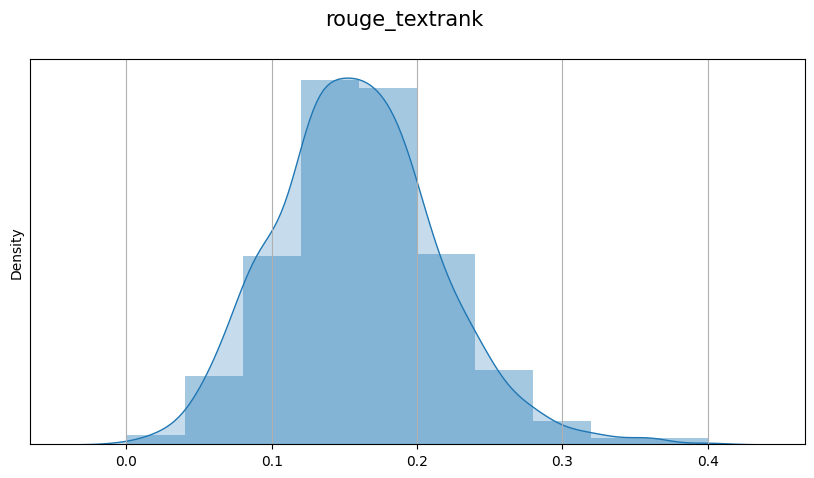

In [ ]:
best_name = name_conv[sum_stats_2.loc['mean',:].idxmax()]
best = pd.DataFrame(list(summary_df_2[best_name]))
plot_distributions(best,'avg rouge', bins=10, title=best_name)
best.describe()

In [ ]:
summary_df_2.to_csv('Summary/summary_1k_red2.csv')

### reduction = 3

In [ ]:
# create a dataframe containing title, text, and target summary
ref_text = []
ref_sum = []

for title in tqdm(title_list_slice):
  cur_df = Data_slice.iloc[map[title]]
  text = '\n\n'.join(cur_df['text_clean'])
  ref_text.append(text)
  sum = ' '.join(cur_df['y_clean'])
  ref_sum.append(sum)

summary_df_3 = pd.DataFrame({'title':title_list_slice, 'ref_text':ref_text, 'ref_sum':ref_sum})
summary_df_3

100%|██████████| 1000/1000 [00:00<00:00, 1597.79it/s]


,title,ref_text,ref_sum
0,How to Survive Your Freshman Year in High School2,Though freshmen in high school aren't quite as...,Be especially outgoing at first. Try out diffe...
1,How to Deal With Emotional Abuse from Your Par...,If you feel threatened or upset with your pare...,Find safe places in your home. Go to a safe pl...
2,How to Pass the Bar Exam,There are three ways to study for the Bar exam...,Assess your options in light of your particula...
3,How to Clean Gravel2,Use tin snips or heavy shears to cut a 2x2 foo...,Cut a section of metal hardware cloth. Shape t...
4,How to Get a Self Published Book into Libraries,Many people are wary of self-published books b...,Ensure that your book is high quality. Be prof...
...,...,...,...
995,How to Do Dance Aerobics1,It is important to warm up at the beginning of...,March in place. Do a hip roll. Squat and pump ...
996,How to Put on a Captive Ring1,"Depending on the location of your piercing, yo...",Wait three months after the initial piercing. ...
997,How to Bake Fluffy Pound Cake with a Variety o...,"Once that is set up, whip the butter with a ha...",Put the butter in a metal or a deep glass bowl...
998,How to Attend Crisis Intervention Counseling,"A crisis can be many things, and may vary from...",Identify a crisis situation. Find a clinic ser...


In [ ]:
# initialize tokenizer and stemmer
tokenizer = Tokenizer(LANGUAGE)
stemmer = Stemmer(LANGUAGE)
red_factor = 3

# summarize lsa
print('summarize lsa...')
summarizer = SummarizerLsa(stemmer)
summarizer.stop_words = get_stop_words(LANGUAGE)
summary_df_3['sum_lsa'] = summary_df_3['ref_text'].progress_apply(lambda x: summarize(x, tokenizer, stemmer, summarizer, red_factor))
summary_df_3['sum_lsa_bypar'] = summary_df_3['ref_text'].progress_apply(lambda x: summarize_bypar(x, tokenizer, stemmer, summarizer, red_factor))

# summarize TextRank
print('summarize TextRank...')
summarizer = SummarizerTextRank(stemmer)
summarizer.stop_words = get_stop_words(LANGUAGE)
summary_df_3['sum_textrank'] = summary_df_3['ref_text'].progress_apply(lambda x: summarize(x, tokenizer, stemmer, summarizer, red_factor))
summary_df_3['sum_textrank_bypar'] = summary_df_3['ref_text'].progress_apply(lambda x: summarize_bypar(x, tokenizer, stemmer, summarizer, red_factor))

# summarize Random
print('summarize random...')
summarizer = SummarizerRandom(stemmer)
summarizer.stop_words = get_stop_words(LANGUAGE)
summary_df_3['sum_random'] = summary_df_3['ref_text'].progress_apply(lambda x: summarize(x, tokenizer, stemmer, summarizer, red_factor))
summary_df_3['sum_random_bypar'] = summary_df_3['ref_text'].progress_apply(lambda x: summarize_bypar(x, tokenizer, stemmer, summarizer, red_factor))

# evaluete summary
print('evaluation...')
summary_df_3['rouge_lsa'] = summary_df_3.progress_apply(lambda x: evaluate_summary(x.ref_sum, x.sum_lsa),axis=1)
summary_df_3['rouge_lsa_bypar'] = summary_df_3.progress_apply(lambda x: evaluate_summary(x.ref_sum, x.sum_lsa_bypar),axis=1)
summary_df_3['rouge_textrank'] = summary_df_3.progress_apply(lambda x: evaluate_summary(x.ref_sum, x.sum_textrank),axis=1)
summary_df_3['rouge_textrank_bypar'] = summary_df_3.progress_apply(lambda x: evaluate_summary(x.ref_sum, x.sum_textrank_bypar),axis=1)
summary_df_3['rouge_random'] = summary_df_3.progress_apply(lambda x: evaluate_summary(x.ref_sum, x.sum_random),axis=1)
summary_df_3['rouge_random_bypar'] = summary_df_3.progress_apply(lambda x: evaluate_summary(x.ref_sum, x.sum_random_bypar),axis=1)

summarize lsa...


100%|██████████| 1000/1000 [00:44<00:00, 22.47it/s]


summarize TextRank...


100%|██████████| 1000/1000 [00:39<00:00, 25.26it/s]


summarize random...


100%|██████████| 1000/1000 [00:01<00:00, 525.42it/s]


evaluation...


100%|██████████| 1000/1000 [00:04<00:00, 236.01it/s]


In [ ]:
summary_df_3.head()

,title,ref_text,ref_sum,sum_lsa,sum_lsa_bypar,sum_textrank,sum_textrank_bypar,sum_random,sum_random_bypar,rouge_lsa,rouge_lsa_bypar,rouge_textrank,rouge_textrank_bypar,rouge_random,rouge_random_bypar
0,How to Survive Your Freshman Year in High School2,Though freshmen in high school aren't quite as...,Be especially outgoing at first. Try out diffe...,"So, say hi to the girl in your French class, b...","So, say hi to the girl in your French class, b...",Though freshmen in high school aren't quite as...,If you get wrapped up in a high school relatio...,Your lunch table doesn't have to be set in sto...,Though you may have met your dream lover in yo...,"{'rouge-1': 0.1, 'rouge-2': 0.0, 'rouge-L': 0....","{'rouge-1': 0.1, 'rouge-2': 0.0, 'rouge-L': 0....","{'rouge-1': 0.14, 'rouge-2': 0.0, 'rouge-L': 0...","{'rouge-1': 0.1, 'rouge-2': 0.0, 'rouge-L': 0....","{'rouge-1': 0.15, 'rouge-2': 0.03, 'rouge-L': ...","{'rouge-1': 0.1, 'rouge-2': 0.0, 'rouge-L': 0...."
1,How to Deal With Emotional Abuse from Your Par...,If you feel threatened or upset with your pare...,Find safe places in your home. Go to a safe pl...,"If you feel uncomfortable at your own home, it...",You may want to go to the bathroom if you shar...,If you feel threatened or upset with your pare...,If you feel threatened or upset with your pare...,"If one doesn’t work, try and find another one....",Try your best to avoid them if possible. They ...,"{'rouge-1': 0.14, 'rouge-2': 0.01, 'rouge-L': ...","{'rouge-1': 0.14, 'rouge-2': 0.01, 'rouge-L': ...","{'rouge-1': 0.31, 'rouge-2': 0.07, 'rouge-L': ...","{'rouge-1': 0.26, 'rouge-2': 0.08, 'rouge-L': ...","{'rouge-1': 0.14, 'rouge-2': 0.0, 'rouge-L': 0...","{'rouge-1': 0.09, 'rouge-2': 0.03, 'rouge-L': ..."
2,How to Pass the Bar Exam,There are three ways to study for the Bar exam...,Assess your options in light of your particula...,Repeat-takers (especially those who received l...,Repeat-takers (especially those who received l...,There are three ways to study for the Bar exam...,Students who performed well in law school and ...,The subjects tested on the essay portion of th...,A traditional Bar preparation course may not b...,"{'rouge-1': 0.25, 'rouge-2': 0.06, 'rouge-L': ...","{'rouge-1': 0.22, 'rouge-2': 0.06, 'rouge-L': ...","{'rouge-1': 0.23, 'rouge-2': 0.08, 'rouge-L': ...","{'rouge-1': 0.26, 'rouge-2': 0.1, 'rouge-L': 0...","{'rouge-1': 0.25, 'rouge-2': 0.06, 'rouge-L': ...","{'rouge-1': 0.29, 'rouge-2': 0.08, 'rouge-L': ..."
3,How to Clean Gravel2,Use tin snips or heavy shears to cut a 2x2 foo...,Cut a section of metal hardware cloth. Shape t...,Use tin snips or heavy shears to cut a 2x2 foo...,Use tin snips or heavy shears to cut a 2x2 foo...,Shake the sieve to remove dirt and other debri...,Hardware cloth is metal or plastic wire mesh t...,Use a flat-bottomed shovel to place the gravel...,Shape it just enough so that the gravel will s...,"{'rouge-1': 0.2, 'rouge-2': 0.03, 'rouge-L': 0...","{'rouge-1': 0.2, 'rouge-2': 0.03, 'rouge-L': 0...","{'rouge-1': 0.17, 'rouge-2': 0.07, 'rouge-L': ...","{'rouge-1': 0.44, 'rouge-2': 0.12, 'rouge-L': ...","{'rouge-1': 0.34, 'rouge-2': 0.12, 'rouge-L': ...","{'rouge-1': 0.45, 'rouge-2': 0.19, 'rouge-L': ..."
4,How to Get a Self Published Book into Libraries,Many people are wary of self-published books b...,Ensure that your book is high quality. Be prof...,In order to not only get the attention of the ...,"Also, choose your bindings carefully, as libra...",Find out who the acquisitions librarian is (th...,Find out who the acquisitions librarian is (th...,Don't just put your book in the donations bin ...,Find out who the acquisitions librarian is (th...,"{'rouge-1': 0.19, 'rouge-2': 0.03, 'rouge-L': ...","{'rouge-1': 0.18, 'rouge-2': 0.03, 'rouge-L': ...","{'rouge-1': 0.18, 'rouge-2': 0.0, 'rouge-L': 0...","{'rouge-1': 0.15, 'rouge-2': 0.02, 'rouge-L': ...","{'rouge-1': 0.16, 'rouge-2': 0.03, 'rouge-L': ...","{'rouge-1': 0.26, 'rouge-2': 0.08, 'rouge-L': ..."


In [ ]:
# summary stats
sum_stats_3 = compute_sum_stats(summary_df_3, stat = 'avg rouge')
sum_stats_3

,LSA,LSAp,TR,TRp,RND,RNDp
mean,0.135680,0.137250,0.156180,0.150170,0.131790,0.132450
std,0.054294,0.053934,0.058163,0.058540,0.056792,0.058764
CI95±,0.003369,0.003347,0.003609,0.003633,0.003524,0.003647


,rouge-1,rouge-2,rouge-L,avg rouge
count,1000.000000,1000.000000,1000.00000,1000.000000
mean,0.215740,0.049390,0.20305,0.156180
std,0.072926,0.043435,0.06869,0.058163
min,0.000000,0.000000,0.00000,0.000000
25%,0.170000,0.020000,0.16000,0.120000
50%,0.220000,0.040000,0.20000,0.150000
75%,0.260000,0.070000,0.24250,0.190000
max,0.470000,0.290000,0.45000,0.400000


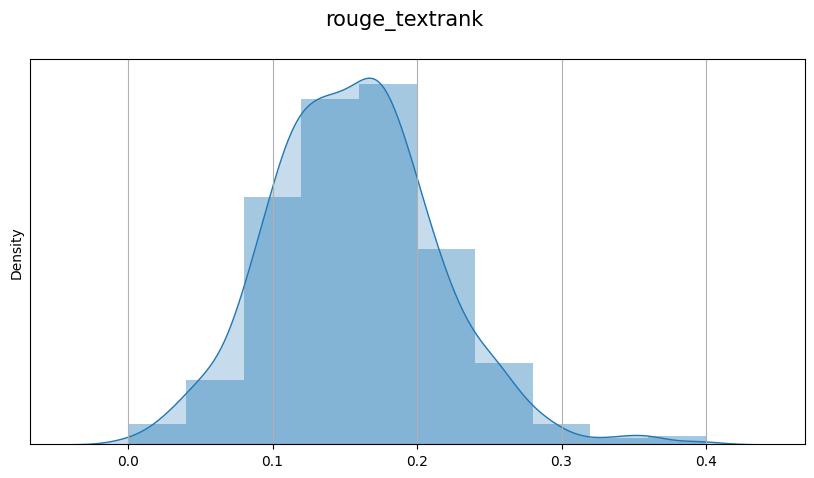

In [ ]:
best_name = name_conv[sum_stats_3.loc['mean',:].idxmax()]
best = pd.DataFrame(list(summary_df_3[best_name]))
plot_distributions(best,'avg rouge', bins=10, title=best_name)
best.describe()

In [ ]:
summary_df_3.to_csv('Summary/summary_1k_red3.csv')

### convergence

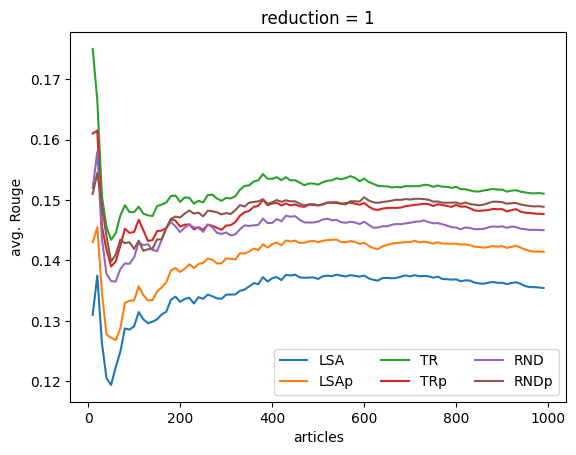

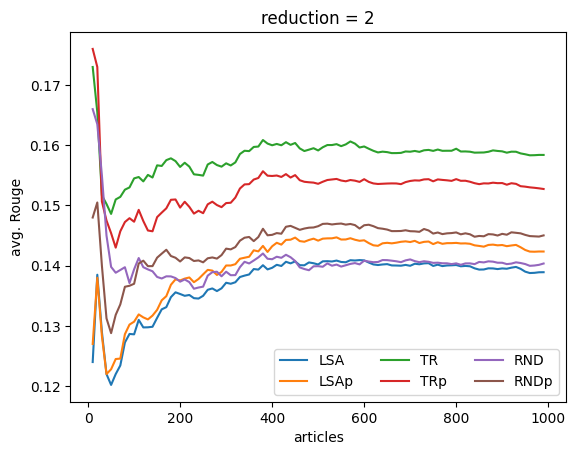

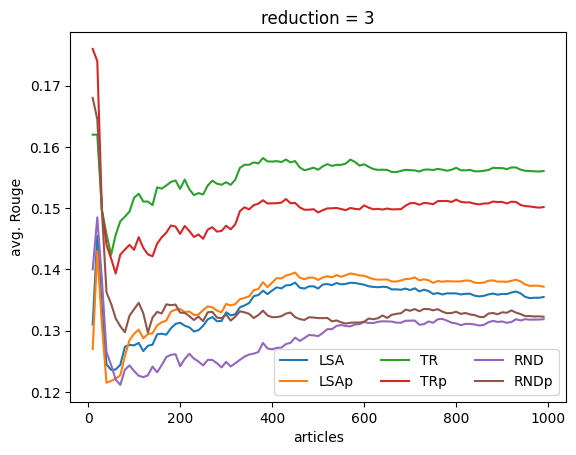

In [ ]:
algs = ['rouge_lsa', 'rouge_lsa_bypar', 'rouge_textrank', 'rouge_textrank_bypar', 'rouge_random', 'rouge_random_bypar']
dfs = [summary_df_1, summary_df_2, summary_df_3]
labels = {'rouge_lsa':'LSA', 'rouge_lsa_bypar':'LSAp', 'rouge_textrank':'TR','rouge_textrank_bypar':'TRp',
          'rouge_random':'RND', 'rouge_random_bypar':'RNDp'}

for i,df in enumerate(dfs):
  for alg in algs:
    test = pd.DataFrame(list(df[alg]))
    cum_mean = []
    for x in range(0,990,10):
      cum_mean.append(test['avg rouge'][0:x+10].mean())
    plt.plot(list(range(10,1000,10)),cum_mean, label=labels[alg])
  plt.ylabel('avg. Rouge')
  plt.xlabel('articles')
  plt.title('reduction = '+str(i+1))
  plt.legend(loc='lower right', ncols=3)
  plt.show()